In [5]:
!unzip Groc_store_data.zip

In [6]:
!unzip acs.zip

# Term Project

# Mapping DC’s Food Deserts using Geo Programming
#### Collaborators: Roman Velazquez and Varun R. Shah

## Introduction:


#### The UN defines a food desert as an area in which ⅓ of the population lives more than 1 mile away from the nearest grocery store. Washington, DC’s food deserts are particularly suited to MCE analysis using programming in Geopandas due to the inherently multifaceted nature of food accessibility.

#### Food accessibility in DC is limited by both the physical distance that people have to travel to reach their nearest grocery store and the relative poverty levels of the people in those neighborhoods.

#### For this project, we used percentage of the population making between 20,000 to 35,000/yr and spending more than 30% of their income on rent. In non-rent-burdened areas, we assume that most people are able to afford cars to drive to their nearest grocery while living outside the 1 mile buffer.




## Datasets Used:

#### 1. Tract Data for Washington DC
#### 2. Grocery Stores Data
#### 3. Census Data in Washington DC for Household Income by Gross Rent as a percentage of household income in the past 12 months. *Source: Census Data API: Variables in /data/2017/acs/acs1/groups/B25074*
#### 4. Extracting Tract data for the above census populations.

## Methodology:

#### The methods for this project includes statistics on rent burdened households in the DC area. To do this, we find the percent of households that are paying more than 30% of income on rent. Next we compute the rate of rent burden using the sum of household variables in categories paying > 30% divided by the total households in 20-35k range for each census tract.


#### We then draw a 1 mile buffer around each of the grocery store locations in DC.

#### Using this methodology, we include a map of rent burdened neighborhoods on top of our grocery stores buffer in order to visualize them both. We then run a Difference-type overlay to include only the areas that were rent burdened and also occurred outside the 1 mile buffer around our grocery store locations.


#### We also find the Rent Burdened Population that fall within the one-mile buffer to compare with the populations outside of it.

In [123]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd 

## Data Preparation 

### Loading Tract Data for Washington DC

In [124]:
import geopandas as gpd
dc_shp = gpd.read_file('./tl_2017_11_tract.shp')
dc_shp.head(2)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,11,001,010900,11001010900,109,Census Tract 109,G5020,S,2379832,2936613,+38.8132450,-077.0238468,"POLYGON ((-77.03919 38.80050, -77.03913 38.800..."
1,11,001,010400,11001010400,104,Census Tract 104,G5020,S,2744444,83,+38.8499425,-077.0004103,"POLYGON ((-77.00919 38.83918, -77.00915 38.839..."


#### Checking the CRS of the Tract Data

In [125]:
dc_shp.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

### Loading Grocery Store Data

In [126]:
groceryStores = gpd.read_file('./Groc_stores/Grocery_Store_Locations.geojson')
groceryStores.head()

,OBJECTID,STORENAME,ADDRESS,PHONE,PRESENT90,PRESENT95,PRESENT00,PRESENT05,PRESENT08,NOTES,...,SSL,PRESENT13,PRESENT14,PRESENT15,PRESENT16,PRESENT17,ZIPCODE,PRESENT18,GIS_ID,geometry
0,1,Target,7828 GEORGIA AVE NW,2028923822,None,None,None,None,None,None,...,2960 0017,None,None,None,None,None,20012,None,GroceryStorePt_1,POINT (-77.02698 38.98446)
1,2,International Progresso Market,7719 GEORGIA AVE NW,2025455015,None,None,None,None,None,None,...,2961 0810,None,None,None,None,None,20012,None,GroceryStorePt_2,POINT (-77.02607 38.98346)
2,3,Jocelyn’s Market,6404 GEORGIA AVE NW,2027227574,None,None,None,None,None,None,...,2945 0839,None,None,None,None,None,20012,None,GroceryStorePt_3,POINT (-77.02780 38.96777)
3,4,Magruder's,5626 CONNECTICUT AVE NW,2024644946,Yes,Yes,Yes,Yes,Yes,,...,1860 0013,Yes,Yes,Yes,Yes,Yes,20015,Yes,GroceryStorePt_4,POINT (-77.07646 38.96555)
4,5,Safeway,5545 CONNECTICUT AVE NW,2022446097,No,Yes,Yes,Yes,Yes,,...,1867 0092,Yes,Yes,Yes,Yes,Yes,20015,Yes,GroceryStorePt_5,POINT (-77.07491 38.96460)


In [91]:
#storeTypes = groceryStores.groupby(groceryStores['STORENAME']).count()

#### Checking the CRS of the Grocery Store data

In [127]:
groceryStores.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Loading Census Data

In [6]:
censusData = pd.read_html('https://api.census.gov/data/2017/acs/acs1/groups/B25074.html', header=0)
censusData = censusData[0]
censusData.head()

,Name,Label,Concept,Required,Attributes,Limit,Predicate Type,Group,Unnamed: 8
0,B25074_001E,Estimate!!Total,HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,int,B25074,NaN
1,B25074_001EA,Annotation of Estimate!!Total,HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,string,B25074,NaN
2,B25074_001M,Margin of Error!!Total,HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,int,B25074,NaN
3,B25074_001MA,Annotation of Margin of Error!!Total,HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,string,B25074,NaN
4,B25074_002E,"Estimate!!Total!!Less than $10,000",HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,int,B25074,NaN


## Data Preprocessing

### CRS Transformation

In [128]:
# Converting Tract Data crs to to UTM zone to get the distances in metres
dc_shp.to_crs('EPSG: 32618', inplace=True)
dc_shp.crs

<Derived Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [129]:
# Changing the CRS to UTM zone to get the distances in metres

groceryStores.to_crs('EPSG: 32618', inplace=True)
groceryStores.crs

<Derived Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Cleaning Tract Data

In [130]:
# remove columns from Tiger shapefiles that are not needed
dc_shp.drop(columns=['NAMELSAD','MTFCC','FUNCSTAT','ALAND','AWATER','INTPTLAT','INTPTLON'], inplace=True)
dc_shp.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,geometry
0,11,001,010900,11001010900,109,"POLYGON ((322920.285 4296612.851, 322926.377 4..."
1,11,001,010400,11001010400,104,"POLYGON ((325620.083 4300848.842, 325624.133 4..."
2,11,001,009903,11001009903,99.03,"POLYGON ((332607.872 4306320.398, 332788.959 4..."
3,11,001,009904,11001009904,99.04,"POLYGON ((332102.747 4305902.959, 332148.564 4..."
4,11,001,009905,11001009905,99.05,"POLYGON ((332650.125 4305314.553, 332657.168 4..."


### Cleaning CensusData

In [133]:
censusData.head()

,Name,Label,Concept,Required,Attributes,Limit,Predicate Type,Group,Unnamed: 8
0,B25074_001E,Estimate!!Total,HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,int,B25074,NaN
1,B25074_001EA,Annotation of Estimate!!Total,HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,string,B25074,NaN
2,B25074_001M,Margin of Error!!Total,HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,int,B25074,NaN
3,B25074_001MA,Annotation of Margin of Error!!Total,HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,string,B25074,NaN
4,B25074_002E,"Estimate!!Total!!Less than $10,000",HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,int,B25074,NaN


#### Extracting census data for populations with household income between 20,000 and 34,999, with household income by Gross Rent as a percentage of household income in the past 12 months. We then download the tract data for these populations.

#### Method used: Pattern Matching and regex

In [146]:
# Filtering the data that contains the substring: 20,000 to extract household incomes between 20,000 and 35,000
census_filtered = censusData[censusData['Label'].str.contains(pat='20,000')]
census_filtered.head()

,Name,Label,Concept,Required,Attributes,Limit,Predicate Type,Group,Unnamed: 8
76,B25074_020E,"Estimate!!Total!!$20,000 to $34,999",HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,int,B25074,NaN
77,B25074_020EA,"Annotation of Estimate!!Total!!$20,000 to $34,999",HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,string,B25074,NaN
78,B25074_020M,"Margin of Error!!Total!!$20,000 to $34,999",HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,int,B25074,NaN
79,B25074_020MA,"Annotation of Margin of Error!!Total!!$20,000 ...",HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,string,B25074,NaN
80,B25074_021E,"Estimate!!Total!!$20,000 to $34,999!!Less than...",HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,int,B25074,NaN


In [141]:
# Filtering the data by removing the rows that includes the substrings: "Annotation of" and "Margin of Error". We only keep the Estimate Total
string_search = ['Annotation of', 'Margin of Error']
census_filtered2 = census_filtered[~census_filtered['Label'].str.contains('|'.join(string_search))]
census_filtered2.head()

,Name,Label,Concept,Required,Attributes,Limit,Predicate Type,Group,Unnamed: 8
76,B25074_020E,"Estimate!!Total!!$20,000 to $34,999",HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,int,B25074,NaN
80,B25074_021E,"Estimate!!Total!!$20,000 to $34,999!!Less than...",HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,int,B25074,NaN
84,B25074_022E,"Estimate!!Total!!$20,000 to $34,999!!20.0 to 2...",HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,int,B25074,NaN
88,B25074_023E,"Estimate!!Total!!$20,000 to $34,999!!25.0 to 2...",HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,int,B25074,NaN
92,B25074_024E,"Estimate!!Total!!$20,000 to $34,999!!30.0 to 3...",HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE...,predicate-only,NaN,0,int,B25074,NaN


In [142]:
# Creating a list from the filtered census:
rent_variables = census_filtered2['Name'].tolist()
rent_variables

['B25074_020E',
 'B25074_021E',
 'B25074_022E',
 'B25074_023E',
 'B25074_024E',
 'B25074_025E',
 'B25074_026E',
 'B25074_027E',
 'B25074_028E']

#### Downloading Tract data for the selected populations

In [180]:
from census import Census
from us import states

# using census API key to start a download session
session = Census("3eb09768e24de33a00bd9620786440fed55d3144")

In [181]:
# using session to download variables based on their name, geography and year
dc_census = session.acs5.state_county_tract(fields = ('NAME', *rent_variables ),
                                      state_fips = states.DC.fips,
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2017)

In [185]:
# Converting the census data retrieved into a dataframe
dc_df = pd.DataFrame(dc_census)
dc_df.head()

,NAME,B25074_020E,B25074_021E,B25074_022E,B25074_023E,B25074_024E,B25074_025E,B25074_026E,B25074_027E,B25074_028E,state,county,tract
0,"Census Tract 21.02, District of Columbia, Dist...",182.0,23.0,0.0,0.0,9.0,11.0,77.0,62.0,0.0,11,001,002102
1,"Census Tract 22.02, District of Columbia, Dist...",116.0,25.0,0.0,0.0,0.0,23.0,35.0,33.0,0.0,11,001,002202
2,"Census Tract 23.02, District of Columbia, Dist...",86.0,0.0,0.0,0.0,0.0,0.0,0.0,86.0,0.0,11,001,002302
3,"Census Tract 34, District of Columbia, Distric...",120.0,7.0,0.0,8.0,0.0,29.0,53.0,23.0,0.0,11,001,003400
4,"Census Tract 58, District of Columbia, Distric...",64.0,0.0,0.0,0.0,0.0,21.0,10.0,33.0,0.0,11,001,005800


In [186]:
# Creating dictionary of name replacements
variable_dict = {
'B25074_020E':'Total_Hhs_20_35',
'B25074_021E':'Total_Hhs_20_35_LT_20',
'B25074_022E':'Total_Hhs_20_35_GT_20_LT_25',
'B25074_023E':'Total_Hhs_20_35_GT_25_LT_30',
'B25074_024E':'Total_Hhs_20_35_GT_30_LT_35',
'B25074_025E':'Total_Hhs_20_35_GT_35_LT_40',
'B25074_026E':'Total_Hhs_20_35_GT_40_LT_50',
'B25074_027E':'Total_Hhs_20_35_GT_50',
'B25074_028E':'Total_HHs_20_35_not_computed',
}

In [187]:
# use .rename and the dictionary to replace our variable names
dc_df.rename(columns=variable_dict, inplace=True)
dc_df.head(2)

,NAME,Total_Hhs_20_35,Total_Hhs_20_35_LT_20,Total_Hhs_20_35_GT_20_LT_25,Total_Hhs_20_35_GT_25_LT_30,Total_Hhs_20_35_GT_30_LT_35,Total_Hhs_20_35_GT_35_LT_40,Total_Hhs_20_35_GT_40_LT_50,Total_Hhs_20_35_GT_50,Total_HHs_20_35_not_computed,state,county,tract
0,"Census Tract 21.02, District of Columbia, Dist...",182.0,23.0,0.0,0.0,9.0,11.0,77.0,62.0,0.0,11,001,002102
1,"Census Tract 22.02, District of Columbia, Dist...",116.0,25.0,0.0,0.0,0.0,23.0,35.0,33.0,0.0,11,001,002202


#### Finding the percent of households that are paying more than 30% of income in rent we will need to do two things. First we get our numerator (sum of household variables in categories paying > 30%) and our denominator (total households in 10-20k range - rent not-computed households)

In [188]:
# creating the measure of rent burden 
dc_df['P_Rent_Burdened'] = (dc_df['Total_Hhs_20_35_GT_30_LT_35'] + 
                            dc_df['Total_Hhs_20_35_GT_35_LT_40'] + 
                            dc_df['Total_Hhs_20_35_GT_40_LT_50'] + 
                            dc_df['Total_Hhs_20_35_GT_50'] )/(
    
                            dc_df['Total_Hhs_20_35'] -
                            dc_df['Total_HHs_20_35_not_computed']) *100
dc_df.head(2)

,NAME,Total_Hhs_20_35,Total_Hhs_20_35_LT_20,Total_Hhs_20_35_GT_20_LT_25,Total_Hhs_20_35_GT_25_LT_30,Total_Hhs_20_35_GT_30_LT_35,Total_Hhs_20_35_GT_35_LT_40,Total_Hhs_20_35_GT_40_LT_50,Total_Hhs_20_35_GT_50,Total_HHs_20_35_not_computed,state,county,tract,P_Rent_Burdened
0,"Census Tract 21.02, District of Columbia, Dist...",182.0,23.0,0.0,0.0,9.0,11.0,77.0,62.0,0.0,11,001,002102,87.362637
1,"Census Tract 22.02, District of Columbia, Dist...",116.0,25.0,0.0,0.0,0.0,23.0,35.0,33.0,0.0,11,001,002202,78.448276


In [79]:
# create a new copy of data of interest. 
dc_df2 = dc_df[[ 'state', 'county', 'tract','P_Rent_Burdened']].copy()

#### Extracting GEOID by merging state, county and tract.

In [80]:
# Create variable GEOID 
dc_df2.loc[:,"GEOID"] = dc_df["state"] + dc_df["county"] + dc_df["tract"]
dc_df2["GEOID"] 

0      11001002102
1      11001002202
2      11001002302
3      11001003400
4      11001005800
          ...     
174    11001008803
175    11001009301
176    11001009504
177    11001000501
178    11001001301
Name: GEOID, Length: 179, dtype: object

In [21]:
# Checking the tract data
dc_shp.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,geometry
0,11,001,010900,11001010900,109,"POLYGON ((322920.285 4296612.851, 322926.377 4..."
1,11,001,010400,11001010400,104,"POLYGON ((325620.083 4300848.842, 325624.133 4..."
2,11,001,009903,11001009903,99.03,"POLYGON ((332607.872 4306320.398, 332788.959 4..."
3,11,001,009904,11001009904,99.04,"POLYGON ((332102.747 4305902.959, 332148.564 4..."
4,11,001,009905,11001009905,99.05,"POLYGON ((332650.125 4305314.553, 332657.168 4..."


In [81]:
# Checking the census with tract data
dc_df2.head()

,state,county,tract,P_Rent_Burdened,GEOID
0,11,001,002102,87.362637,11001002102
1,11,001,002202,78.448276,11001002202
2,11,001,002302,100.000000,11001002302
3,11,001,003400,87.500000,11001003400
4,11,001,005800,100.000000,11001005800


#### Merging Census Tract Data with Tract data (Tiger shape files), on GEOID.

In [82]:
# merging Tract only data with Census Tract data, merging both with GEOID
dc_join = dc_shp.merge(right=dc_df2, how='left',on='GEOID', validate='one_to_one')
dc_join.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,geometry,state,county,tract,P_Rent_Burdened
0,11,001,010900,11001010900,109,"POLYGON ((322920.285 4296612.851, 322926.377 4...",11,001,010900,100.000000
1,11,001,010400,11001010400,104,"POLYGON ((325620.083 4300848.842, 325624.133 4...",11,001,010400,94.560669
2,11,001,009903,11001009903,99.03,"POLYGON ((332607.872 4306320.398, 332788.959 4...",11,001,009903,100.000000
3,11,001,009904,11001009904,99.04,"POLYGON ((332102.747 4305902.959, 332148.564 4...",11,001,009904,87.421384
4,11,001,009905,11001009905,99.05,"POLYGON ((332650.125 4305314.553, 332657.168 4...",11,001,009905,88.073394


<AxesSubplot:title={'center':'% of $20-35k Households \n Rent Burdened'}>

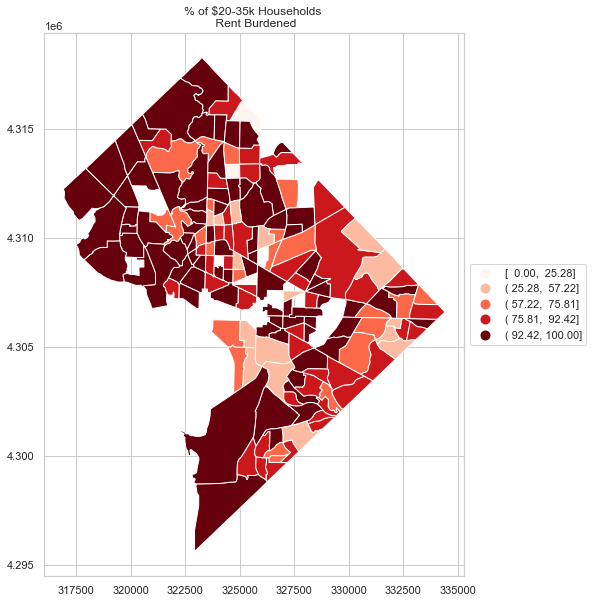

In [84]:
fig, ax = plt.subplots(figsize=(10, 10))  # Create a figure containing a single axes.
ax.set_title("% of $20-35k Households \n Rent Burdened")  # Add a title to the axes.
dc_join.plot(ax=ax, column='P_Rent_Burdened', scheme='NaturalBreaks', k=5, 
             cmap='Reds', legend=True,legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),'interval': True})


#### Filling Missing values and water area

In [85]:
water = gpd.read_file('https://opendata.arcgis.com/datasets/db65ff0038ed4270acb1435d931201cf_24.geojson')

<AxesSubplot:title={'center':'% of $20-35k Households \n Rent Burdened 2017'}>

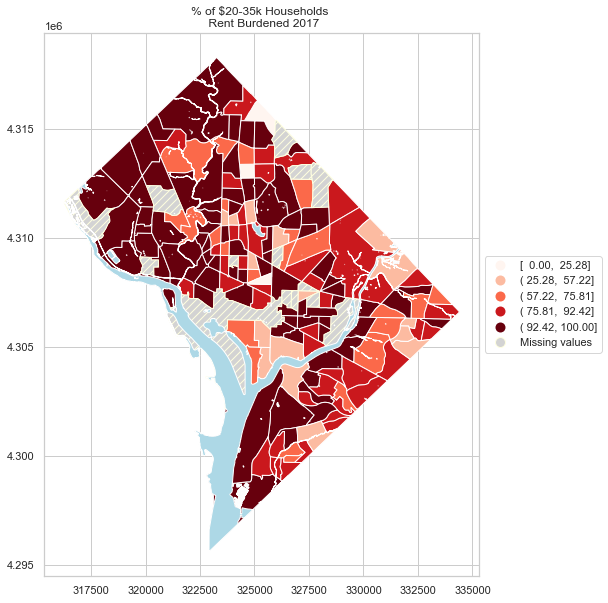

In [86]:
fig, ax = plt.subplots(figsize=(10, 10))   
ax.set_title("% of $20-35k Households \n Rent Burdened 2017")   
dc_join.plot(ax=ax, column='P_Rent_Burdened', scheme='NaturalBreaks', k=5, \
             cmap='Reds', legend=True,
             legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),'interval': True},
             missing_kwds={"color": "lightgrey","edgecolor": "lightyellow","hatch": "///","label": "Missing values",})
water.to_crs('EPSG: 32618').plot(ax = ax, color='lightblue')

Text(0.5, 1.0, 'DC Grocery Stores Locations')

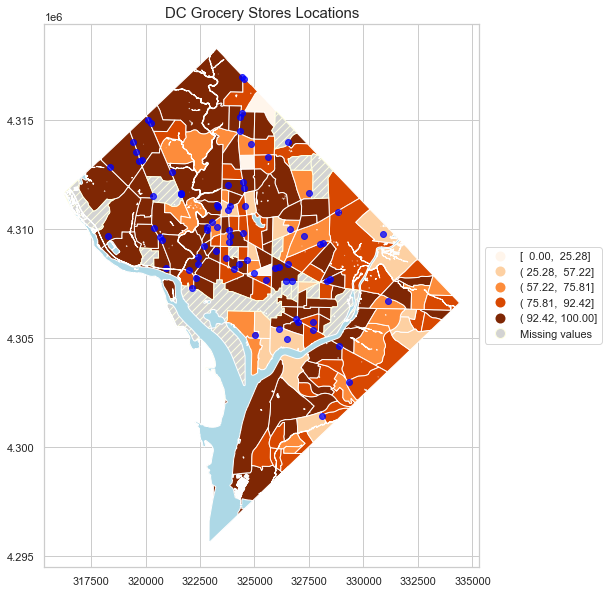

In [189]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
#dc_shp.plot(ax = ax, color = 'orange', edgecolor = 'dodgerblue', alpha = 0.75)
dc_join.plot(ax=ax, column='P_Rent_Burdened', scheme='NaturalBreaks', k=5, \
             cmap='Oranges', legend=True,
             legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),'interval': True},
             missing_kwds={"color": "lightgrey","edgecolor": "lightyellow","hatch": "///","label": "Missing values",})
groceryStores.plot(ax = ax, color = 'blue', alpha = 0.75)
water.to_crs('EPSG: 32618').plot(ax = ax, color='lightblue')
ax.set_title('DC Grocery Stores Locations', fontdict = {'fontsize': '15', 'fontweight' : '3'})

#### Creating a 1 mile buffer around Grocery Store points. 1 mile = 1609 meters

In [87]:
# create a buffer for 500m
stores_buffer = groceryStores.buffer(1609)

In [89]:
#stores_buffer

#### Plotting Buffer area without the census tract data

Text(0.5, 1.0, 'DC Grocery Stores Locations')

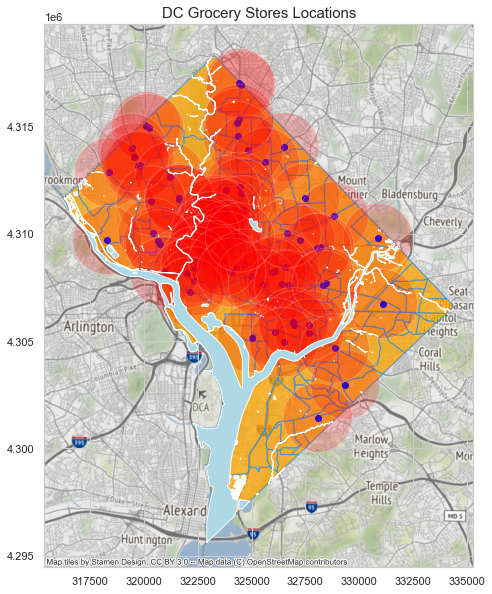

In [190]:
import contextily as cx

fig, ax = plt.subplots(1, 1, figsize = (10, 10))
dc_shp.plot(ax = ax, color = 'orange', edgecolor = 'dodgerblue', alpha = 0.75)
groceryStores.plot(ax = ax, color = 'blue', alpha = 1)
stores_buffer.plot(ax = ax, color='red', alpha=.2)
water.to_crs('EPSG: 32618').plot(ax = ax, color='lightblue')
cx.add_basemap(ax, crs=groceryStores.crs.to_string())
ax.set_title('DC Grocery Stores Locations', fontdict = {'fontsize': '15', 'fontweight' : '3'})

Text(0.5, 1.0, 'DC Grocery Stores Locations with Rent Burdened in percentage')

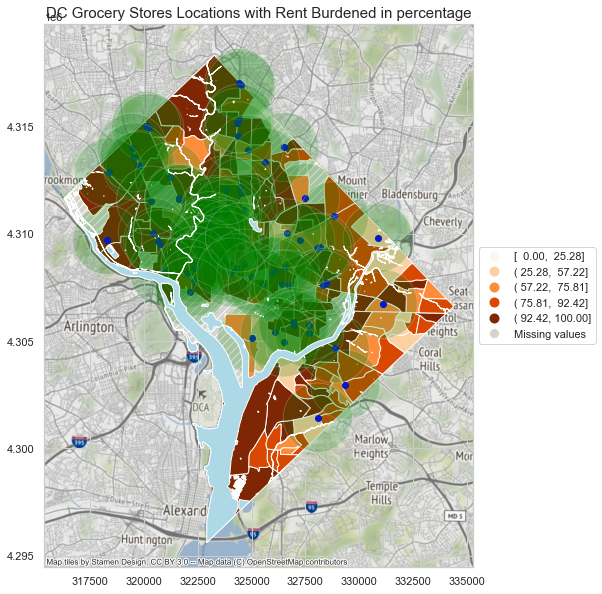

In [191]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
dc_join.plot(ax=ax, column='P_Rent_Burdened', scheme='NaturalBreaks', k=5, \
             cmap='Oranges', legend=True,
             legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),'interval': True},
             missing_kwds={"color": "lightgrey","edgecolor": "lightyellow","hatch": "///","label": "Missing values",})
groceryStores.plot(ax = ax, color = 'blue', alpha = 1)
stores_buffer.plot(ax = ax, color='green', alpha=0.2)
water.to_crs('EPSG: 32618').plot(ax = ax, color='lightblue')
cx.add_basemap(ax, crs=groceryStores.crs.to_string())
ax.set_title('DC Grocery Stores Locations with Rent Burdened in percentage', fontdict = {'fontsize': '15', 'fontweight' : '3'})

In [119]:
def plot_overlay(overlay_type, overlay_result,column=None):
    '''Plot the overlay result on a map and add the outlines of the original shapefiles on top.'''

    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize = (10, 10))

    if column is None:
        column = overlay_result.index.values
    # Plot overlay data
    overlay_result.to_crs('EPSG:32618').plot(ax = ax, column=column,cmap = 'Set2', edgecolor = 'black')

    water.to_crs('EPSG: 32618').plot(ax = ax, color='lightblue')
    cx.add_basemap(ax, crs=groceryStores.crs.to_string())

    # Stylize plots
    plt.style.use('bmh')

    # Set title
    ax.set_title('Overlay Results: {0}'.format(overlay_type), fontdict = {'fontsize': '15', 'fontweight' : '3'})

#### Making a copy of GroceryStores Dataframe and updating the Geometry to Stores_buffer

In [35]:
groceryStoresCopy = groceryStores.copy()
groceryStoresCopy['geometry'] = stores_buffer

#### Finding Food Deserts by extracting Tract data which does not intersect with the 1 mile buffer. Overlay using 'difference'

In [37]:
# erase tract with Buffers and reproject to  'epsg:32618'
food_deserts = gpd.overlay(dc_join.to_crs('EPSG:32618'), 
                                 groceryStoresCopy.to_crs('EPSG:32618'), 
                                 how = 'difference')
food_deserts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,geometry,state,county,tract,P_Rent_Burdened
0,11,001,010900,11001010900,109,"POLYGON ((322920.285 4296612.851, 322926.377 4...",11,001,010900,100.000000
1,11,001,010400,11001010400,104,"POLYGON ((325624.133 4300890.836, 325637.177 4...",11,001,010400,94.560669
2,11,001,009903,11001009903,99.03,"POLYGON ((332788.959 4306315.681, 332857.997 4...",11,001,009903,100.000000
3,11,001,009904,11001009904,99.04,"POLYGON ((332660.037 4306251.232, 332668.619 4...",11,001,009904,87.421384
4,11,001,009905,11001009905,99.05,"POLYGON ((332650.125 4305314.553, 332657.168 4...",11,001,009905,88.073394


#### Plotting the areas that are out of buffer zones

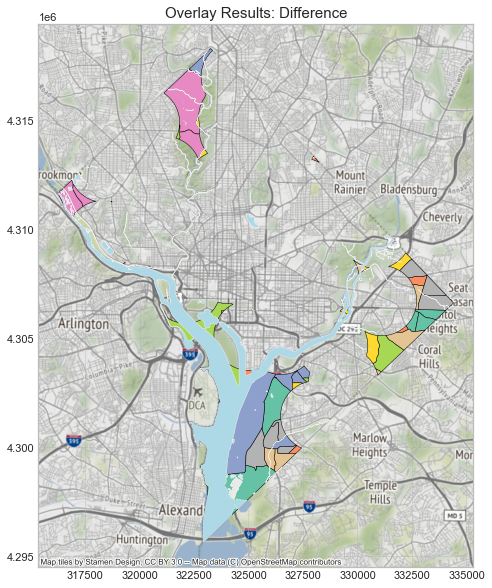

In [120]:
plot_overlay(overlay_type = "Difference", overlay_result = food_deserts)

In [213]:
# DC Quadrants
quad = gpd.read_file('https://opendata.arcgis.com/datasets/02923e4697804406b9ee3268a160db99_11.geojson')
quad  = quad[['QUADRANT','geometry']]

#### Adding DC Quadrants on the Map

Text(0.5, 1.0, 'DC Tracts that fall outside of the 1-mile buffer')

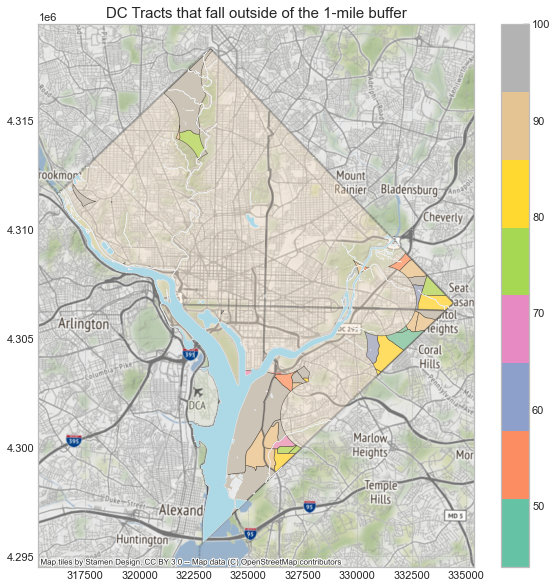

In [217]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

food_deserts.plot(ax = ax, column='P_Rent_Burdened',cmap = 'Set2', edgecolor = 'black', legend=True)
                  #to_crs('epsg:4326')
quad.to_crs('EPSG: 32618').plot(ax = ax, color = 'bisque', edgecolor = 'dimgray',linewidth=2, alpha = 0.35)
water.to_crs('EPSG: 32618').plot(ax = ax, color='lightblue')
cx.add_basemap(ax, crs=groceryStores.crs.to_string())
ax.set_title('DC Tracts that fall outside of the 1-mile buffer', fontdict = {'fontsize': '15', 'fontweight' : '3'})

In [232]:
food_desert_quad = gpd.overlay(food_deserts, quad.to_crs('EPSG:32618'), how='identity')
food_desert_quad.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,state,county,tract,P_Rent_Burdened,QUADRANT,geometry
0,11,001,010900,11001010900,109,11,001,010900,100.000000,SW,"POLYGON ((322926.377 4296648.358, 322942.749 4..."
1,11,001,010400,11001010400,104,11,001,010400,94.560669,SW,"MULTIPOLYGON (((325735.339 4302018.631, 325735..."
2,11,001,006400,11001006400,64,11,001,006400,56.000000,SW,"POLYGON ((325336.085 4303551.895, 325489.253 4..."
3,11,001,010200,11001010200,102,11,001,010200,62.500000,SW,"POLYGON ((323788.610 4306261.831, 323831.633 4..."
4,11,001,011000,11001011000,110,11,001,011000,69.318182,SW,"POLYGON ((325143.800 4303439.727, 325141.613 4..."


### The Distribution of Rent Burdened Households by Quandrants outside the buffer

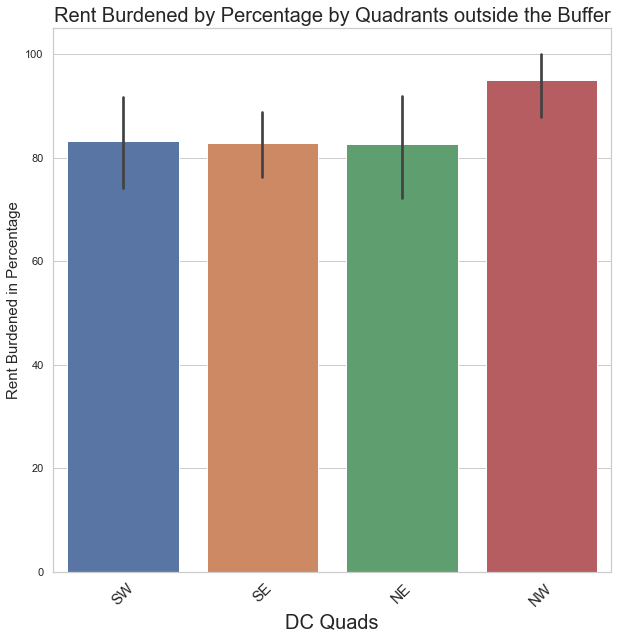

In [235]:
import seaborn as sns
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize = (10,10))

X = 'QUADRANT'
Y = 'P_Rent_Burdened'

ax = sns.barplot(x=X, y=Y, data=food_desert_quad)
plt.xticks(rotation=45, horizontalalignment="center", fontsize=15)
plt.xlabel("DC Quads", fontsize=20)
plt.ylabel("Rent Burdened in Percentage", fontsize=15)
plt.title("Rent Burdened by Percentage by Quadrants outside the Buffer", fontsize=20)

plt.show()

In [158]:
dc_df.head(2)

,NAME,Total_Hhs_20_35,Total_Hhs_20_35_LT_20,Total_Hhs_20_35_GT_20_LT_25,Total_Hhs_20_35_GT_25_LT_30,Total_Hhs_20_35_GT_30_LT_35,Total_Hhs_20_35_GT_35_LT_40,Total_Hhs_20_35_GT_40_LT_50,Total_Hhs_20_35_GT_50,Total_HHs_20_35_not_computed,state,county,tract
0,"Census Tract 21.02, District of Columbia, Dist...",182.0,23.0,0.0,0.0,9.0,11.0,77.0,62.0,0.0,11,001,002102
1,"Census Tract 22.02, District of Columbia, Dist...",116.0,25.0,0.0,0.0,0.0,23.0,35.0,33.0,0.0,11,001,002202


In [172]:
food_deserts_hhs = food_deserts.merge(right=dc_df[['Total_Hhs_20_35', 'tract']], how='left', on='tract', validate='one_to_one')
food_deserts_hhs.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,geometry,state,county,tract,P_Rent_Burdened,Total_Hhs_20_35
0,11,001,010900,11001010900,109,"POLYGON ((322920.285 4296612.851, 322926.377 4...",11,001,010900,100.000000,250.0
1,11,001,010400,11001010400,104,"POLYGON ((325624.133 4300890.836, 325637.177 4...",11,001,010400,94.560669,239.0
2,11,001,009903,11001009903,99.03,"POLYGON ((332788.959 4306315.681, 332857.997 4...",11,001,009903,100.000000,51.0
3,11,001,009904,11001009904,99.04,"POLYGON ((332660.037 4306251.232, 332668.619 4...",11,001,009904,87.421384,159.0
4,11,001,009905,11001009905,99.05,"POLYGON ((332650.125 4305314.553, 332657.168 4...",11,001,009905,88.073394,109.0


In [225]:
food_desert_hhs_quad = gpd.overlay(food_deserts_hhs, quad.to_crs('EPSG:32618'), how='identity')
food_desert_hhs_quad.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,state,county,tract,P_Rent_Burdened,Total_Hhs_20_35,QUADRANT,geometry
0,11,001,010900,11001010900,109,11,001,010900,100.000000,250.0,SW,"POLYGON ((322926.377 4296648.358, 322942.749 4..."
1,11,001,010400,11001010400,104,11,001,010400,94.560669,239.0,SW,"MULTIPOLYGON (((325735.339 4302018.631, 325735..."
2,11,001,006400,11001006400,64,11,001,006400,56.000000,173.0,SW,"POLYGON ((325336.085 4303551.895, 325489.253 4..."
3,11,001,010200,11001010200,102,11,001,010200,62.500000,16.0,SW,"POLYGON ((323788.610 4306261.831, 323831.633 4..."
4,11,001,011000,11001011000,110,11,001,011000,69.318182,264.0,SW,"POLYGON ((325143.800 4303439.727, 325141.613 4..."


### The Distribution of Households having income between 20-35k, in food deserts

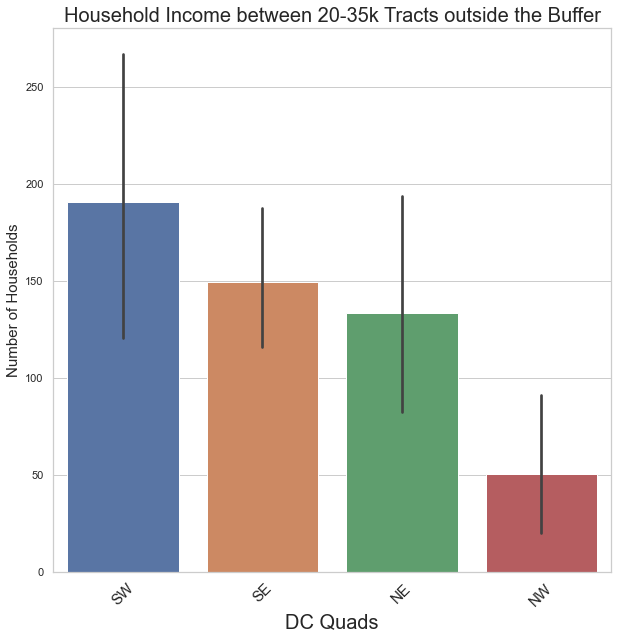

In [234]:
import seaborn as sns
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize = (10,10))

X = 'QUADRANT'
Y = 'Total_Hhs_20_35'

ax = sns.barplot(x=X, y=Y, data=food_desert_hhs_quad)
plt.xticks(rotation=45, horizontalalignment="center", fontsize=15)
plt.xlabel("DC Quads", fontsize=20)
plt.ylabel("Number of Households", fontsize=15)
plt.title("Household Income between 20-35k Tracts outside the Buffer", fontsize=20)

plt.show()

### Conclusion and Findings

#### In conclusion, we looked at the DC Grocery Stores data and plotted along with the Census Data with Households with income 20-35k. We also looked at Rent-Burdened households in this income bracket, households that are spending 30% or more of their income on their rent. We looked at the Food Deserts in DC area by creating a 1-mile buffer around the grocery stores across DC, and looked at how the income groups and rent burdened households in this income group get impacted. The findings showed us the households that are most Rent Burdened and in food desert are in the North West Quadrant of Washington, DC and the overall number of households in this income group and falling in the food desert are the highest in the South West Quadrant of Washington DC.